In [4]:
from datasets import Dataset, DatasetDict, Image, Features
import pandas as pd
from PIL import Image as PILImage
import numpy as np

# train_size = 4158
# test_size = 945
train_size = 1034
test_size = 188
image_size = 1024

# Generate file paths for training and testing sets
image_paths_train = [f'data/train_image_{image_size}/image_{i}.jpg' for i in range(train_size)]
label_paths_train = [f'data/train_annotation_{image_size}/annotation_{i}.png' for i in range(train_size)]
image_paths_validation = [f'data/test_image_{image_size}/image_{i}.jpg' for i in range(test_size)]
label_paths_validation = [f'data/test_annotation_{image_size}/annotation_{i}.png' for i in range(test_size)]

def create_dataset(image_paths, label_paths):
    
    dataset = Dataset.from_dict({"pixel_values": sorted(image_paths),
                                "label": sorted(label_paths)})
    dataset = dataset.cast_column("pixel_values", Image())
    dataset = dataset.cast_column("label", Image())
    return dataset


# step 1: create Dataset objects
train_dataset = create_dataset(image_paths_train, label_paths_train)
validation_dataset = create_dataset(image_paths_validation, label_paths_validation)

# step 2: create DatasetDict
dataset = DatasetDict({
     "train": train_dataset,
     "validation": validation_dataset,
     }
)

In [1]:
from torch import nn
import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from transformers import SegformerForSemanticSegmentation
from transformers import TrainingArguments
# from createDataset import dataset
from torchvision.transforms import ColorJitter
from transformers import SegformerImageProcessor
from transformers import TrainingArguments
import torch
from torch import nn
import evaluate
from transformers import Trainer
import matplotlib.pyplot as plt
import matplotlib.image as pltimage
import cv2
# from Segmentation_model import UnetModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# model_path = 'unet_ep500_focalloss.ckpt'
# model = UnetModel.load_from_checkpoint(model_path, torch.device('cpu'))
# model.eval()

# create 'id2label'
# id2label = {0: 'intactwall', 1: 'breakout', 2: 'faultzone', 3: 'wetspot', 4: 'unclassifycracks', 5: 'tectonictrace', 6: 'desiccation', 7: 'faultgauge'}
id2label = {0: 'intactwall', 1: 'tectonictrace', 2: 'desiccation',3: 'faultgauge', 4: 'breakout', 5: 'faultzone',}
# id2label = {0: 'intactwall', 1: 'tectonictrace', 2: 'desiccation',3: 'faultgauge', 4: 'incipientbreakout', 5: 'faultzone',6:'fullybreakout'}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained(pretrained_model_name_or_path='model_ckpt/segformer_model/nowrs-ep500-batch24-512-1409/checkpoint-146000', local_files_only=True)


/home/wangrush/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0


/home/wangrush/.local/lib/python3.10/site-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [4]:
def color_palette():
    """Color palette that maps each class to RGB values.
    
    This one is actually taken from ADE20k.
    """
    return [[4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

palette = color_palette()

In [6]:
from PIL import Image
n = 249
# im_frame = Image.open('data/test_image_512/' + f'image_{n}.jpg')
# np_frame = np.array(im_frame.getdata())
# image_test = Image.open('data/temporal_compare_data/201113_image_2048_overlap_20/' + f'image_{n}.jpg')
image_test = Image.open('data/210202_230816/test_image_512/' + f'image_{n}.jpg')
gt_seg = Image.open('data/210202_230816/test_annotation_512/' + f'annotation_{n}.png')

In [7]:
from torch import nn

inputs = processor(images=image_test, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image_test.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

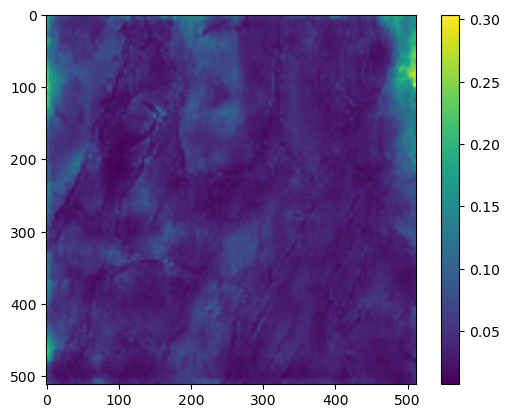

In [8]:
# upsampled_logits
p = torch.nn.functional.softmax(upsampled_logits, dim=1)
p_array = p.detach().numpy()
def calculate_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1) 

entropy_map = calculate_entropy(p_array)
plt.imshow(entropy_map[0])
plt.colorbar()
plt.show()

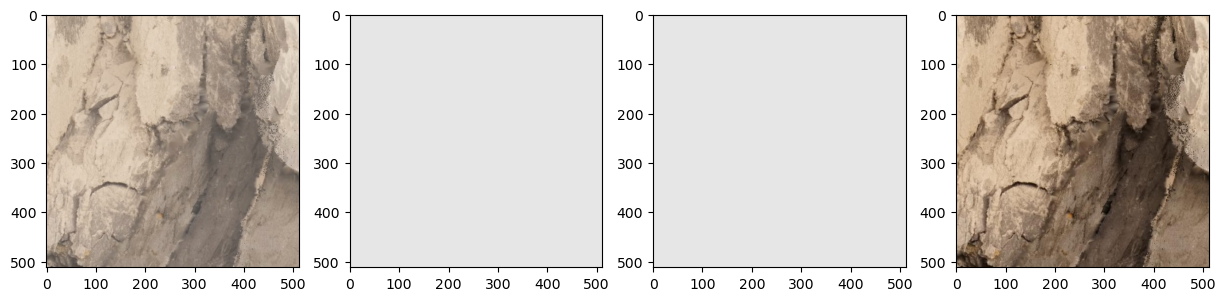

In [9]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = pred_seg.numpy()
gt_segmentation_map = np.array(gt_seg)
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
gt_color_segmentation_map = np.zeros((gt_segmentation_map.shape[0], gt_segmentation_map.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
    gt_color_segmentation_map[gt_segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]
gt_color_seg = gt_color_segmentation_map[..., ::-1]
image_arr = np.array(image_test)
img = image_arr * 0.7 + ground_truth_color_seg * 0.3
img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.imshow(gt_color_seg)
plt.figure(figsize=(15,6))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap="Blues_r")
plt.subplot(1, 4, 2)
plt.imshow(gt_color_seg, cmap="Accent_r")
plt.subplot(1, 4, 3)
plt.imshow(ground_truth_color_seg, cmap="terrain_r")
plt.subplot(1, 4, 4)
plt.imshow(image_arr, cmap="twilight_shifted_r")
plt.show()

In [10]:
def mIOU(prediction, label, num_classes):
    # prediction= prediction.max(1)[1].float().cpu().numpy()
    # label = label.float().cpu().numpy() 
    
    iou_list = list()
    present_iou_list = list()
    # all_iou_list = list()

    for sem_class in range(num_classes):
        # print(sem_class)
        pred_inds = (prediction == sem_class)
        target_inds = (label == sem_class)
        if target_inds.sum().item() == 0:
            iou_now = float('nan')
            # iou_now = 0
            # all_iou_list
        else:
            # print(sem_class)
            intersection_now = (pred_inds[target_inds]).sum().item()
            union_now = pred_inds.sum().item() + target_inds.sum().item() - intersection_now
            iou_now = float(intersection_now) / float(union_now)
            present_iou_list.append(iou_now)
        iou_list.append(iou_now)
    miou = np.mean(present_iou_list)
    return miou, iou_list

In [11]:
m_accuracy=list()
mean_IOU = list()
perClass_IOU = np.arange(6)
test_size = 469 #945
image_size = 512
# 1021 for test set, 5103 for whole
for i in range(test_size): 
    # image = test_ds[i]['pixel_values']
    # gt_seg = test_ds[i]['labels']
    image = Image.open(f'data/210202_230816/test_image_{image_size}/' + f'image_{i}.jpg')
    gt_seg = Image.open(f'data/210202_230816/test_annotation_{image_size}/' + f'annotation_{i}.png')
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
    )
    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]
    pred_arr = np.array(pred_seg)
    gt_arr = np.array(gt_seg)
    acc = np.mean((pred_arr == gt_arr))
    m_accuracy.append(acc)
    m_iou,iou_list = mIOU(pred_arr,gt_arr,6)
    iou_arr = np.array(iou_list)
    mean_IOU.append(m_iou)
    # print(type(perClass_IOU))
    perClass_IOU = np.vstack([perClass_IOU,iou_arr])
    # pltimage.imsave(f'data/result_segformer/result_{i}.png', pred_arr)

In [12]:
# Print results
print("Overall mean IOU:",np.mean(mean_IOU))
print("Overall mean Acc:",np.mean(m_accuracy))
perClass_IOU = perClass_IOU[1:]
print("Per class IOU:", np.nanmean(perClass_IOU,axis = 0))

Overall mean IOU: 0.6775841822039892
Overall mean Acc: 0.9128437733599372
Per class IOU: [0.80588169 0.18990818 0.3467695  0.23596773 0.74968937 0.51499487]


In [13]:
from PIL import Image
allresult = np.zeros((1, 7091,48436))
width = 512
height = 512
num_image = 1485 # 1485  # 392 # 96
col_num = 48436 //(width-20) +1
row_num = 7091//(height-20) +1
horz_flip = True

# p = torch.nn.functional.softmax(upsampled_logits, dim=1)
# p_array = p.detach().numpy()
def calculate_entropy(probs):
    return -np.sum(probs * np.log(probs + 1e-10), axis=1) 



for i in range(num_image):
    # image = test_ds_orig[n]['pixel_values']
    # gt_seg = test_ds_orig[n]['labels']
    image = Image.open('data/temporal_compare_data/201113_image_512_overlap_20/' + f'image_{i}.jpg')
    # gt_seg = Image.open('data/annotation_overlap/' + f'annotation_{i}.png')
    if horz_flip:
        horz_flip_img = image.transpose(method=Image.FLIP_LEFT_RIGHT)
        image = horz_flip_img
    inputs = processor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
    # print(logits.shape)
    # First, rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1], # (height, width)
        mode='bilinear',
        align_corners=False
    )
    ########## Get probability prediction and calculate cross entropy
    # probability = nn.functional.softmax(upsampled_logits, dim = 1)
    # p_array = probability.detach().numpy()
    # entropy_map = calculate_entropy(p_array)
    # pred_arr = entropy_map[0]
    ## probability_singlelayer = probability[0,5]
    ########## Get label prediction 
    # Second, apply argmax on the class dimension
    pred_seg = upsampled_logits.argmax(dim=1)[0]
    pred_arr = pred_seg.detach().numpy()  
    if horz_flip:
        horz_flip_img = pred_arr[:,::-1]
        pred_arr = horz_flip_img
    row_idx = i//col_num
    col_idx = i%col_num
    # print("Current pred unique and shape: ",np.unique(pred_arr))
    # print(row_idx, col_idx,pred_arr.shape)
    if col_idx<(col_num-1):
        col = col_idx*(width-20)          
    elif col_idx==(col_num-1):
        col = 48436 - width                 
    if row_idx<(row_num-1):
        row = row_idx*(height-20)
    elif row_idx==(row_num-1):
        row = 7091 - height
    if col_idx == 0 or col_idx ==(col_num-1) or row_idx ==0 or row_idx ==(row_num-1):
        allresult[:,int(row):int(row)+height, int(col):int(col)+width] = pred_arr
    else:
        allresult[:,int(row)+10:int(row)+height-10, int(col) +10:int(col)+width-10] = pred_arr[10:-10,10:-10]

    # print("All result unique:", np.unique(allresult))
    # gt_arr = np.array(gt_seg)
    # acc = np.mean((pred_arr == gt_arr))
    # m_accuracy.append(acc)
    # m_iou,iou_list = mIOU(pred_arr,gt_arr,8)
    # iou_arr = np.array(iou_list)
    # mean_IOU.append(m_iou)
    # print(type(perClass_IOU))
    # perClass_IOU = np.vstack([perClass_IOU,iou_arr])
    # pltimage.imsave(f'data/result_segformer/result_{i}.png', pred_arr)

In [56]:
get_entropy = False
if get_entropy:
    allresult = allresult*100

In [14]:
import rasterio 
with rasterio.open("data/refined/RadiusCropped.tif") as radiusimg:
    profile = radiusimg.profile

with rasterio.open('data/result/201113_segformer_ep500_1409_512_512.tif', 'w', **profile) as dst:
    dst.write(allresult[0].astype(rasterio.uint8), 1)

In [37]:
# Load groundtruth of 201113, and compare with the prediction
import rasterio 
from rasterio.windows import Window
import numpy as np
from sklearn.metrics import confusion_matrix

groundtruth_path = "data/temporal_compare_data/201113_label/201113_label.tif"
pred_result_path = "data/temporal_compare_data/201113_prediction_augment_nowrs_512_splitarea_512_v2.tif"

classes = np.arange(6)
cm = np.zeros((6,6))
for i in range(5):
    # print(i)
    window = Window(i*10000, 0, 10000,7091)
    with rasterio.open(groundtruth_path) as gtimg:
        groundtruth = gtimg.read(window = window)
        # print(groundtruth.shape)
    # Load groundtruth of 201113, and compare with the prediction
    with rasterio.open(pred_result_path) as predimg:
        prediction = predimg.read(window = window)
        # print(prediction.shape)
    ground_truth = groundtruth.flatten()
    predictions = prediction.flatten()  
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(ground_truth, predictions, labels=classes)
    # print(conf_matrix)
    cm = cm+conf_matrix
    # print(conf_matrix)
print("Done!")

Done!


In [38]:
# Calculate Overall Accuracy
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f'Overall Accuracy: {accuracy:.4f}')

# Calculate Intersection over Union (IoU) and Per-Class IoU
iou_per_class = []
for i in range(6):
    intersection = cm[i, i]
    union = np.sum(cm[i, :]) + np.sum(cm[:, i]) - intersection
    iou = intersection / union if union != 0 else 0
    iou_per_class.append(iou)
    print(f'IoU for class {classes[i]}: {iou:.4f}')

# Calculate Mean IoU
mean_iou = np.mean(iou_per_class)
print(f'Mean IoU: {mean_iou:.4f}')


Overall Accuracy: 0.9458
IoU for class 0: 0.9297
IoU for class 1: 0.2317
IoU for class 2: 0.5226
IoU for class 3: 0.4156
IoU for class 4: 0.8590
IoU for class 5: 0.8345
Mean IoU: 0.6322


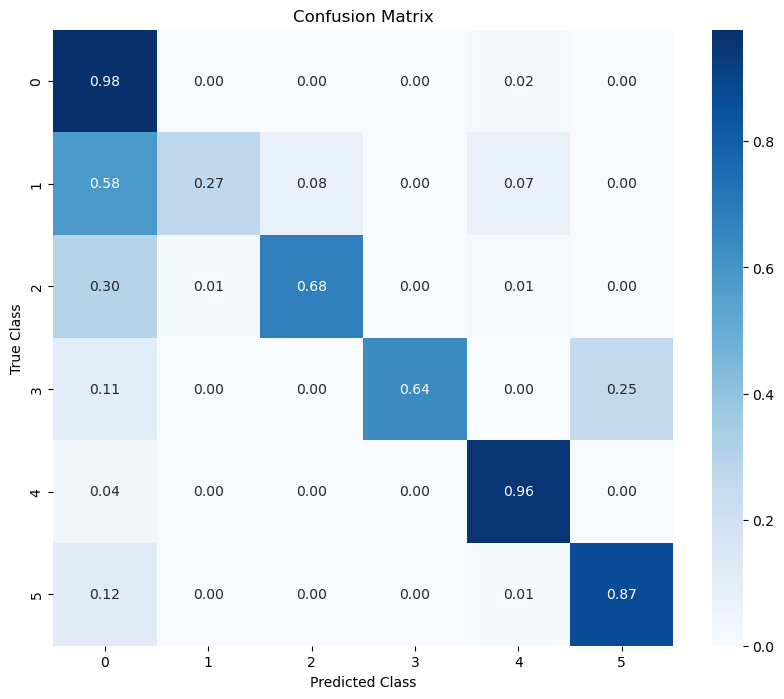

In [34]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix_norm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix_norm, annot=True,fmt=".2f", cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [2]:
import rasterio 
from rasterio.windows import Window
import numpy as np
with rasterio.open("data/temporal_compare_data/201113_prediction_augment_multiscale_splitarea_512.tif") as img1:
    # window = Window(0, 20000, 7000, 20000) window = Window(0, 0, 4000, 4000)
    prediction512 = img1.read(window = Window(20000, 0, 4000, 4000))
with rasterio.open("data/temporal_compare_data/201113_prediction_augment_multiscale_splitarea_1024.tif") as img2:
    # window = Window(0, 20000, 7000, 20000)
    prediction1024 = img2.read(window = Window(20000, 0, 4000, 4000))
with rasterio.open("data/temporal_compare_data/201113_prediction_augment_multiscale_splitarea_2048.tif") as img3:
    # window = Window(0, 20000, 7000, 20000)
    prediction2048 = img3.read(window = Window(20000, 0, 4000, 4000))

In [3]:
# weight the prediction of various features
feature_weight = np.array(([0.6,0.3,0.1],[0.1,0.3,0.6],[0.6,0.3,0.1],[0.1,0.3,0.6],[0.6,0.3,0.1],[0.1,0.3,0.6]))

In [4]:
one_hot_encoded512 = np.eye(6)[prediction512[0].astype(int)]
one_hot_encoded512 = one_hot_encoded512.transpose(2, 0, 1)
one_hot_encoded1024 = np.eye(6)[prediction1024[0].astype(int)]
one_hot_encoded1024 = one_hot_encoded1024.transpose(2, 0, 1)
one_hot_encoded2048 = np.eye(6)[prediction2048[0].astype(int)]
one_hot_encoded2048 = one_hot_encoded2048.transpose(2, 0, 1)

In [5]:
combined_array = np.stack([one_hot_encoded512, one_hot_encoded1024, one_hot_encoded2048], axis=1)  # Shape: (6, 3, 100, 100)

# Define the weight array with shape (6, 3)
weights = np.random.rand(6, 3)  # Example weights

# Multiply the combined array with the weights
weighted_array = combined_array * weights[:, :, np.newaxis, np.newaxis]

# Sum along the second axis to collapse the 3 arrays into one weighted array
weighted_sum = weighted_array.sum(axis=1)  # Shape: (6, 100, 100)

# Find the index of the maximum value along the first axis (class axis)
predicted_outcome = np.argmax(weighted_sum, axis=0)  # Shape: (100, 100)

print(predicted_outcome.shape)  # Should print (100, 100)

(4000, 4000)


In [6]:
with rasterio.open("data/refined/RadiusCropped.tif") as radiusimg:
    profile = radiusimg.profile
    profile.update(width=4000, height=4000)

In [7]:
with rasterio.open('data/temporal_compare_data/test_weightscale_3.tif', 'w', **profile) as dst:
    dst.write(predicted_outcome, 1)

In [55]:
# # Stitch image together
# allresult = np.zeros((7091,48436))
# width = 512
# height = 512
# for i in range(5103):
#     currentresult = pltimage.imread(f'data/result_segformer/result_{i}.png')
#     currentlabel = currentresult[:,:,0]
#     for y in range(27):
#         for x in range(189):
#             if x<188:
#                 col = x*(width/2)                
#             elif x==188:
#                 col = 48436 - width                 
#             if y<26:
#                 row = y*(height/2)
#             elif y==26:
#                 row = 7091 - height
#             allresult[int(row)+128:int(row)+384, int(col) +128:int(col)+384] = currentlabel[128:384,128:384]
            


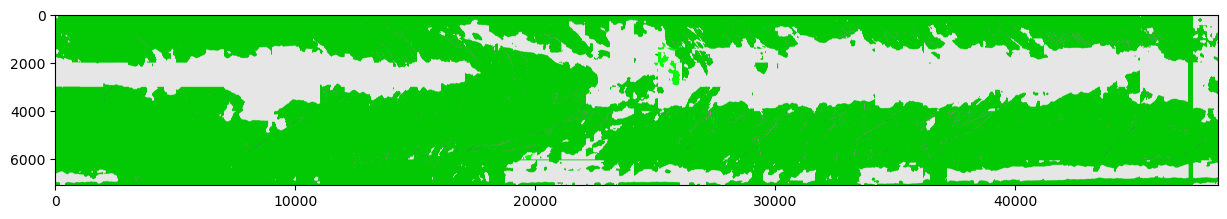

In [54]:
import numpy as np
import matplotlib.pyplot as plt

segmentation_map = allresult
gt_segmentation_map = np.array(gt_seg)
color_segmentation_map = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
gt_color_segmentation_map = np.zeros((gt_segmentation_map.shape[0], gt_segmentation_map.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_segmentation_map[segmentation_map == label, :] = color
    # gt_color_segmentation_map[gt_segmentation_map == label, :] = color
# Convert to BGR
ground_truth_color_seg = color_segmentation_map[..., ::-1]
# gt_color_seg = gt_color_segmentation_map[..., ::-1]
# image_arr = np.array(image_test)
# img = image_arr * 0.7 + ground_truth_color_seg * 0.3
# img = img.astype(np.uint8)

# plt.figure(figsize=(15, 10))
# plt.imshow(img)
# plt.imshow(gt_color_seg)
plt.figure(figsize=(15,6))

plt.imshow(ground_truth_color_seg, cmap="terrain_r")


In [10]:
import rasterio 
with rasterio.open("data/refined/RadiusCropped.tif") as radiusimg:
    profile = radiusimg.profile

with rasterio.open('data/temporal_compare_data/201113_prediction_augment_1024_splitarea_1024.tif', 'w', **profile) as dst:
    dst.write(allresult.astype(rasterio.uint8), 1)

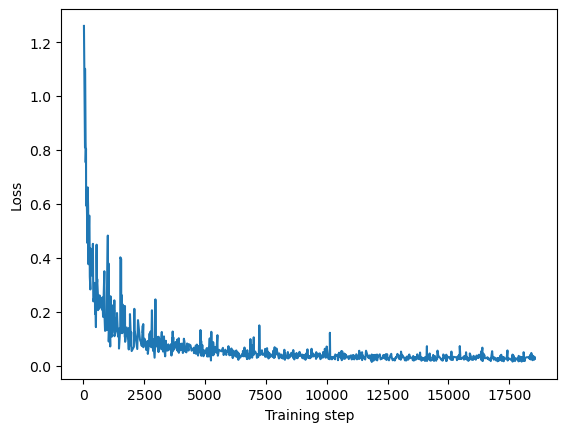

In [14]:

import pandas as pd

loss = pd.read_csv("tensorboard_loss.csv")
import numpy as np
import matplotlib.pyplot as plt
loss_arr = np.array(loss)
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.plot(loss_arr[:,1], loss_arr[:,2])
plt.savefig("loss.png")

In [3]:
import torch 
class_counts = torch.tensor([238765416, 849106, 2401392, 212117, 76447632, 24784013], dtype=torch.float)
sum(class_counts)/class_counts

tensor([1.4385e+00, 4.0450e+02, 1.4303e+02, 1.6192e+03, 4.4927e+00, 1.3858e+01])